# Comunicaciones Digitales - Trabajo Final

## Sensado del espectro - Implementación de método LAD (localization algorithm based on double-thresholding) con combinación de clusters adyacentes para la detección de señales primarias en sistemas de radios cognitivas

**GRUPO .EXE**

* Quinteros, Tomas 41483608
* Recchini, Fabrizio Andres 41440569
* Coschica, Francisco Nicolas 40249149
* Iannelli, Santiago Ariel 41211256
* Don, Enzo Martín 41265934

## **Introducción**

El espectro radioeléctrico es un recurso sumamente limitado y esencial para las transmisiones de radio. En la actualidad, está muy congestionado, la distribución de recursos que se utiliza conduce a un uso ineficiente de las frecuencias para las transmisiones de radio. Se están desarrollando varios tipos de tecnologías que buscan mejorar la eficiencia en la transmisión y asignación de recursos de radio, un ejemplo de estas es la radio cognitiva.

A partir de la problemática planteada se busca desarrollar un tipo de algoritmo que pueda ser utilizado en radio cognitiva para la detección de señales de emisores primarios, específicamente se desarrollará el método LAD (localization algorithm based on double-thresholding) con combinación de clusters adyacentes.

## **Radio Cognitiva**

Actualmente, los factores limitantes para la transmisión radio viene dada por la escasez
de recursos en el espacio radioeléctrico. En ciertas ocasiones se asignan determinadas frecuencias por medio de licencias a emisores (usuarios primarios) los cuales realizan transmisiones en muy contadas ocasiones, causando una infrautilización del espectro asignado.

Una de las líneas de investigación que busca dar solución permitiendo un mayor aprovechamiento del espectro es la Radio Cognitiva cuyo objetivo es permitir el uso del espectro por parte de usuarios secundarios (usuarios que no poseen licencia para transmitir en una determinada frecuencia) en los instantes en los que los usuarios primarios no estén haciendo uso de la frecuencia a la que les fué asignada. Los usuarios secundarios deben de implementar métodos capaces de identificar el momento en que el usuario primario deja de transmitir para poder hacer uso del espectro, como así también poder detectar el momento en que el usuario primario reanuda la transmisión para no producir interferencia y elegir otro rango de frecuencias para transmitir que no posean emisores primarios activos.

Existen distintas técnicas para poder hacer detección de redes y poder realizar un sensado del espectro permitiendo identificar las señales presentes en el espectro analizado.
Como el método a desarrollar en el trabajo es el método LAD, este pertenece a los Detectores de Energía.

## **Detectores de Energía**

Se basan en detectar la potencia recibida en el rango de frecuencias de interés y luego comparar con un umbral previamente calculado para decidir si se ha detectado o no una señal. Es un método de baja complejidad y muy utilizado ya que no requiere de información previa de la señal a detectar, pero presenta tasas de falsa alarma (probabilidad de detectar una señal y que no lo sea) mayores que otros métodos y requieren relaciones señal ruido (SNR) altas para su correcto funcionamiento.

## **Sensado del Espectro: Detectores de Energía**

El sensado del espectro es una de las funciones principales de la Radio Cognitiva ya que le permite conocer la información del entorno en un rango de frecuencias específicas y de esta manera poder identificar transmisiones de usuarios primarios y huecos de transmisión que podrían ser utilizados por un usuario secundario y de esta forma hacer un uso eficiente del espectro.

Particularmente el sensado del espectro a partir de detectores de energía podemos decir que, se asume un modelo de hipótesis para la señal recibida:
$$$$
$$
  H_0 : y(t) = n(t)\\
  H_1 : y(t) = hx(t) + n(t)
$$
$$$$

$x(t)$: Señal del usuario primario a ser detectada por el usuario secundario que está realizando el sensado.

$n(t)$: Ruido aditivo blanco Gaussiano.

$h$: Ganancia del canal desde el transmisor del usuario primario hasta el receptor del usuario secundario.

$H_0$: Hipótesis nula, la cual indica que no existe ningún usuario primario transmitiendo
en la banda que se analiza.

$H_1$: Hipótesis, indica la existencia de un usuario primario.

$$
\\
$$

El estadístico utilizado generalmente por este tipo de detectores es la energía media del total de las N muestras observadas:

$$$$
$$
\begin{align*}
T = \frac{1}{N}\sum_{t=1}^N |y(t)|^2
\end{align*}
$$
$$$$

La decisión para realizar la detección de la existencia de una cierta señal en el espacio radioeléctrico se basa en la comparación del anterior estadístico con un umbral determinado $λ$.

El rendimiento de este tipo de métodos se caracteriza a través de las probabilidades de falsa alarma $P_F$ y de detección $P_D$.

$P_F$ indica la probabilidad de decidir la hipótesis $H_1$ cuando en realidad la hipótesis correcta es $H_0$:
$$$$
$$
\begin{align*}
P_F = P_r(T > λ|H_0)
\end{align*}
$$
$$$$

$P_D$ indica la probabilidad de decidir correctamente la hipótesis $H_1$:
$$$$
$$
\begin{align*}
P_D = P_r(T > λ|H_1)
\end{align*}
$$
$$$$

Un buen detector deberá asegurar una buena probabilidad de detección y minimizar todo lo posible la probabilidad de falsa alarma o deben establecerse ciertos límites que permitan garantizar una determinada eficiencia sobre el espectro, calidad de servicio o asegurar cierta protección a los usuarios primarios.

Por lo que podemos concluir que el objetivo principal de los detectores de energía consiste en la búsqueda de un umbral adecuado para la decisión.

In [32]:
!pip install SigMF

In [33]:
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics as st
from sigmf import SigMFFile, sigmffile
import sys

## **Desarrollo del Trabajo: Sensado del espectro mediante método LAD**

El método LAD (Location Algorithm based on double-thresholding) es un método del tipo detección de energía y como su nombre lo indica es un algoritmo de localización basado en doble umbral. Adicionalmente se le puede aplicar una mejora al algoritmo el cual permite una mejor identificación de las señales detectadas, este es LAD con combinación de clusters adyacentes.

**Fundamentos del método:**
El modelo del sistema que se asume en este método, considera la recepción de una señal discreta cuya base es la siguiente:

$$$$
$$
\begin{align*}
r(n) = \sum_{k=1}^m i_k(n) + w(n)
\end{align*}
$$
$$$$

$m$: número de señales desconocidas.

$i_k$: k-ésima señal recibida.

$w(n)$: ruido.

$$
\\
$$

En primer lugar lo que hacemos es definir la fuente de muestras a utilizar, si se desea obtener las muestras directamente desde PlutoSDR completar la variable source_type con "PlutoSDR" y si se desea utilizar un archivo que contenga una captura hecha previamente se debe completar con "File":

In [37]:
# Valores posibles para la fuente de muestras
# PlutoSDR
# File
source_type = "File"

En caso de elegir como fuente de muestras PlutoSDR, a continuación se completan los valores de configuración para la captura:

In [12]:
import adi

# Frecuencia de muestreo
sample_rate_plutosdr = 2.4e6     # Hz
# Frecuencia central
center_freq_plutosdr = 94.6e6    # Hz
# Numero de muestras a capturar
number_of_samples_plutosdr = 102400
# IP PlutoSDR
ip_number_plutosdr = "ip:192.168.1.36"
# Tipo de ganancia de recepcion
gain_control_mode_plutosdr = 'slow_attack'

En caso de elegir como fuente de muestras un archivo, se completa con el directorio donde se encuentra el archivo con la captura. Es importante aclarar que el archivo a utilizar debe respetar las convenciones de la libreria SigMF al igual que contener el archivo de metadatos correspondiente.

In [38]:
# Archivo con la señal capturada que se va a analizar
path_signal_file = '/content/sample_capture.sigmf-data'

Luego se definen variables comunes a utilizar:

In [39]:
# Unidad de frecuencia a graficar
frec_unit = 10**6    # MHz

# Probabilidades de falsa alarma para el umbral superior y umbral inferior respectivamente
pfa1 = 0.0001e-14
pfa2 = 0.001e-7

# Porcentaje de elementos para la muestra inicial Q
percent_elements = 0.01

# Valor en frecuencia [HZ] de la distancia entre dos clusters de señales para considerar que los mismos pertenecen a la misma señal
dist_frec = 400000 # Hz

Luego se obtiene la información de la señal capturada según el tipo de fuente de muestras elegida, en nuestro caso vamos a utilizar un archivo el cual contiene una captura del espectro de FM utilizando el SDR Adalm Pluto en el Laboratorio de Comunicaciones Digitales.

La señal capturada es la siguiente:

*   Frecuencia Central: 94.6 MHz.
*   Ancho de banda de 2.4 MHz, permitiendo observar señales desde 93.4 MHz hasta 95.8 MHz.

De esta forma podemos observar las señales de las distintas estaciones FM que se encuentran en el rango anterior.

In [40]:
sample_rate = 0
center_freq = 0
number_of_samples = 0

if source_type == "PlutoSDR":

   # IP de PlutoSDR
   sdr = adi.Pluto(ip_number_plutosdr)

   # Tipo de ganancia de recepcion
   sdr.gain_control_mode_chan0 = gain_control_mode_plutosdr

   sdr.rx_lo = int(center_freq_plutosdr)
   sdr.sample_rate = int(sample_rate_plutosdr)
   sdr.rx_rf_bandwidth = int(sample_rate_plutosdr)
   sdr.rx_buffer_size = number_of_samples_plutosdr

   # Captura de muestras
   sdr_signal = sdr.rx()/2**14

   sample_rate = sample_rate_plutosdr
   center_freq = center_freq_plutosdr
   number_of_samples = number_of_samples_plutosdr

elif source_type == "File":

   signal_file = sigmffile.fromfile(path_signal_file)
   sdr_signal = signal_file.read_samples().view(np.complex64).flatten()
   sample_rate = signal_file.get_global_field(SigMFFile.SAMPLE_RATE_KEY)
   signal_capture = signal_file.get_capture_info(0)
   center_freq = signal_capture.get(SigMFFile.FREQUENCY_KEY, 0)
   number_of_samples = len(sdr_signal)

else:
   print("El tipo de fuente de muestras no es correcto. Completar la variable source_type con PlutoSDR o File")
   sys.exit()

# Distancia en frecuencia [Hz] entre las muestras
dist_of_samples = sample_rate/number_of_samples

Se calcula la Densidad Espectral de Potencia (PSD) del espectro capturado mediante los siguientes pasos:
*   Se calcula la FFT de la señal capturada.
*   Valor absoluto y se eleva al cuadrado para obtener la potencia.
*   Se hace un reordenamiento de las muestras para mover a 0 Hz la frecuencia central y que las frecuencias negativas queden a la izquierda.
*   Normalización.
*   Se pasa a dB usando $10log_{10}()$.




In [41]:
signal_PSD = (np.abs(np.fft.fft(sdr_signal)))**2
signal_PSD_shifted = np.fft.fftshift(signal_PSD)
signal_PSD_shifted_normalized = signal_PSD_shifted / (number_of_samples*sample_rate)
signal_PSD_dB = 10.0*np.log10(signal_PSD_shifted_normalized)

Observamos la PSD del espectro capturado:

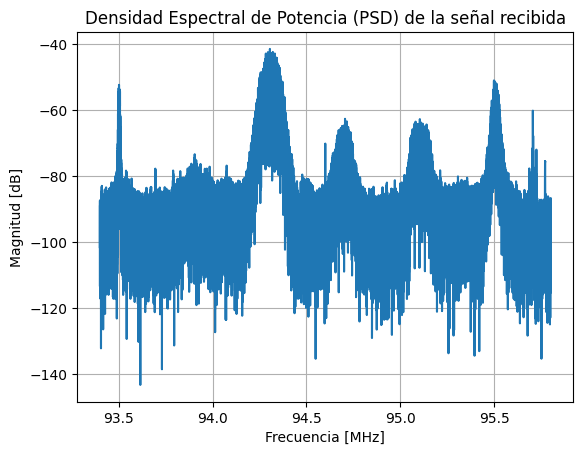

In [42]:
# Rango de frecuencias a analizar
f_sdr_signal = np.arange(center_freq - (sample_rate/2), center_freq + (sample_rate/2), (sample_rate/number_of_samples))

fig, signal_psd_dB_plot = plt.subplots()
signal_psd_dB_plot.plot(f_sdr_signal/frec_unit, signal_PSD_dB)
signal_psd_dB_plot.grid()
signal_psd_dB_plot.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Magnitud [dB]')
plt.title('Densidad Espectral de Potencia (PSD) de la señal recibida')
plt.show()

A partir de la densidad espectral de potencia PSD se obtiene la potencia de cada una de las muestras multiplicando los valores de la PSD por la distancia entre las muestras.

Se normalizan los valores de potencia a partir del maximo valor.

Se grafica la potencia normalizada y tambien se grafica en terminos de dB.

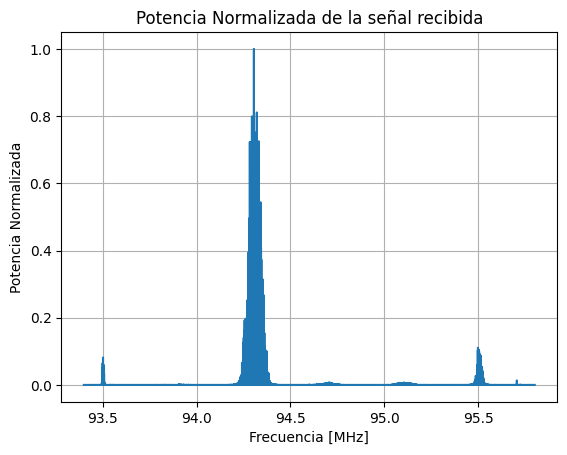

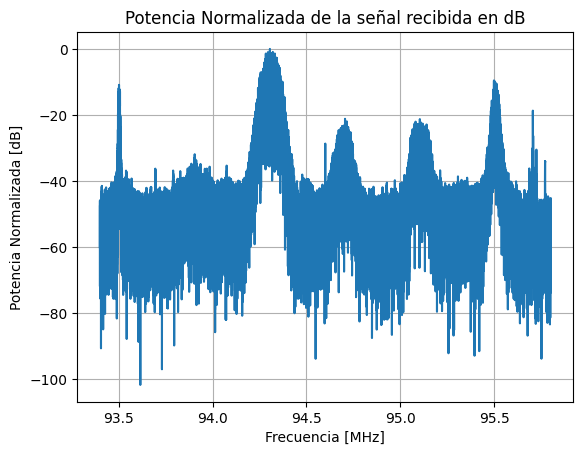

In [43]:
# Multiplico cada uno de los valores de la PSD por la distancia entre muestras para obtener la potencia de cada muestra
signal_power_shifted = signal_PSD_shifted_normalized * dist_of_samples
# Normalizo los valores de potencia a partir del maximo valor
signal_power_shifted_normalized = signal_power_shifted / max(signal_power_shifted)
signal_power_dB = 10.0*np.log10(signal_power_shifted_normalized)

# Potencia de la señal recibida
power_of_signal_r = signal_power_shifted_normalized

fig, signal_power_plot = plt.subplots()
signal_power_plot.plot(f_sdr_signal/frec_unit, power_of_signal_r)
signal_power_plot.grid()
signal_power_plot.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Potencia Normalizada')
plt.title('Potencia Normalizada de la señal recibida')
plt.show()

fig, signal_power_db_plot = plt.subplots()
signal_power_db_plot.plot(f_sdr_signal/frec_unit, signal_power_dB)
signal_power_db_plot.grid()
signal_power_db_plot.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Potencia Normalizada [dB]')
plt.title('Potencia Normalizada de la señal recibida en dB')
plt.show()

## **Cálculo del Umbral Superior $T_{sup}$ y Umbral Inferior $T_{inf}$**

Como se mencionó anteriormente, el método está basado en el cálculo de dos umbrales los cuales se obtienen de forma iterativa mediante el algoritmo FCME.

El algoritmo **FCME (Forward Consecutive Mean Excision)** o en español **Escisión de Media Consecutiva Adelante**, es un método iterativo en el cual se establece un umbral propio del algoritmo ($T_{umbral}$) para separar las muestras en dos conjuntos, las señales concentradas y el ruido. Para la determinación de este umbral depende de la elección de la **muestra inicial $Q$** y el **Factor de Umbral $T_{cme}$**.

Para obtener la muestra inicial $Q$, primero se realiza un ordenamiento de las muestras de la señal de manera ascendente según los valores de energía y luego para formar $Q$ se toma un porcentaje de las muestras más pequeñas, en nuestro caso el 1%.

In [44]:
# Creamos un arreglo de tuplas. En el primer valor cada tupla tendrá el valor de la potencia de la señal,
# en el segundo valor tendrá la frecuencia al que corresponde ese valor de potencia.
r_signal_array = []
for i in range(0,len(power_of_signal_r)):
  r_signal_array.append((power_of_signal_r[i],f_sdr_signal[i]))

# Ordenamos las muestras de manera creciente según su potencia.
sorted_r_signal_array = sorted(r_signal_array, key=lambda x: x[0])

# Indice para graficar las muestras de manera creciente según su potencia.
samples_index = np.linspace(0,(number_of_samples-1),number_of_samples)

Luego el valor $T_{cme}$ se obtiene:
$$$$
$$
\begin{align*}
T_{cme} = -ln(P_{fa})
\end{align*}
$$
$$$$

Donde **$P_{fa}$** es la **Probabilidad de Falsa Alarma** que indica la probabilidad de decidir la hipótesis $H_1$ cuando en realidad la hipótesis correcta es la $H_0$. Por lo tanto para realizar una buena detección es necesario que $P_{fa}$ no sea muy chico ya que permitiría asegurar que se está detectando muestras pertenecientes a la señal pero dejando fuera muestras que también lo podrían ser y que tampoco sea un valor muy grande ya que se estarían incluyendo muestras de ruido como pertenecientes a la señal.

Luego para llevar adelante el algoritmo FCME se deben realizar iterativamente estos pasos 1 y 2 hasta llegar a la condición de parada:

**Paso 1: Cálculo del $T_{umbral}$**
$$$$
$$
\begin{align*}
T_{umbral} = T_{cme}\frac{1}{Q}\sum_{i=1}^Q |x_i|^2
\end{align*}
$$
$$$$

Consiste en calcular la media de los valores de la muestra inicial $Q$ y multiplicar por el valor de $T_{cme}$.

**Paso 2: Obtención de la nueva muestra $Q$**

La muestra $Q$ ahora estará formada por todos los valores de energía que sean menores al $T_{umbral}$ calculado. Por lo que se vuelve a ejecutar el Paso 1 con este set de muestras $Q$ actualizado hasta que suceda alguna de estas dos condiciones de parada:

*   El $T_{umbral}$ de la iteración actual es igual al $T_{umbral}$ calculado en la iteración anterior, eso significa que las muestras consideradas en la iteración actual y la iteración anterior son las mismas, por lo tanto no tiene sentido seguir iterando porque se obtendría el mismo valor de umbral.
*   La cantidad de muestras de la iteración actual son menores o iguales a la cantidad de muestras obtenidas en la iteración anterior, es decir, este incremento del valor del umbral no aumenta o hasta podría disminuir el número de muestras que se encuentran por debajo del umbral.

Luego de cumplidas alguna de las dos condiciones de parada, el último valor de $T_{umbral}$ será el valor del umbral calculado por el algoritmo FCME.

Como se mencionó, el método LAD se caracteriza por la utilización de dos umbrales, por lo tanto solo bastará con ejecutar el procedimiento anterior dos veces con distintos valores de $P_{fa}$ para obtener los dos umbrales, el **umbral superior $T_{sup}$** y el **umbral inferior $T_{inf}$**, donde se cumple lo siguiente $P_{fa1} < P_{fa2}$, donde $P_{fa1}$ corresponde a $T_{sup}$ y $P_{fa2}$ corresponde a $T_{inf}$, teniendo por lo tanto que $T_{sup} > T_{inf}$.

Para el calculo de los umbrales se defino la funcion calculate_threshold:

In [45]:
def calculate_threshold(pfa):

    Tcme = -np.log(pfa)

    flag = 1
    # Muestra Inicial Q: toma un procentaje (percent_elements) de los elementos partiendo desde el extremo de menor potencia
    initial_samples=sorted_r_signal_array[0:math.ceil((percent_elements*len(sorted_r_signal_array)))]
    threshold = Tcme*st.mean([x[0] for x in initial_samples])
    threshold_old = 0

    tuple_item_threshold_old = []
    for tuple_item in sorted_r_signal_array:
        if tuple_item[0] < threshold_old:
            tuple_item_threshold_old.append(tuple_item)

    len_tuple_item_threshold_old = len(tuple_item_threshold_old)

    while(flag):

        tuple_item_threshold = []
        for tuple_item in sorted_r_signal_array:
            if tuple_item[0] < threshold:
                tuple_item_threshold.append(tuple_item)

        len_tuple_item_threshold = len(tuple_item_threshold)

        if threshold == threshold_old or len_tuple_item_threshold <= len_tuple_item_threshold_old:
            flag = 0
        else:
            len_tuple_item_threshold_old = len_tuple_item_threshold
            threshold_old = threshold
            threshold = Tcme*st.mean([x[0] for x in tuple_item_threshold])

    return threshold

Donde esta función se llama dos veces, primero pasandole como argumento $P_{fa1}$ para el calculo del umbral superior $T_{sup}$ y luego $P_{fa2}$ para el calculo del umbral inferior $T_{inf}$.

Los valores de umbrales obtenidos son los siguientes:

In [46]:
tu = calculate_threshold(pfa1)
tl = calculate_threshold(pfa2)

print("Umbral Superior: ")
print(tu)
print("Umbral Inferior:")
print(tl)

Umbral Superior: 
0.016745125150161452
Umbral Inferior:
0.0025847540603801244


Graficando las muestras que se encuentran ordenadas de manera creciente por potencia junto con los umbrales calculados tenemos:

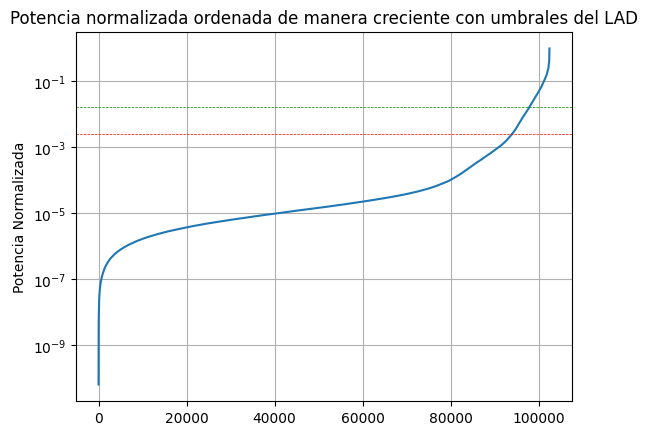

In [47]:
fig, signal_power_sorted_t = plt.subplots()
signal_power_sorted_t.plot(samples_index, [x[0] for x in sorted_r_signal_array])
signal_power_sorted_t.axhline(y=tu, color='green', linestyle='--',linewidth=0.5)
signal_power_sorted_t.axhline(y=tl, color='red', linestyle='--',linewidth=0.5)
signal_power_sorted_t.grid()
signal_power_sorted_t.set_yscale('log')
signal_power_sorted_t.set(ylabel = 'Potencia Normalizada')
plt.title('Potencia normalizada ordenada de manera creciente con umbrales del LAD')
plt.show()

Colocando los umbrales sobre el espectro que muestra la potencia normalizada se tiene:

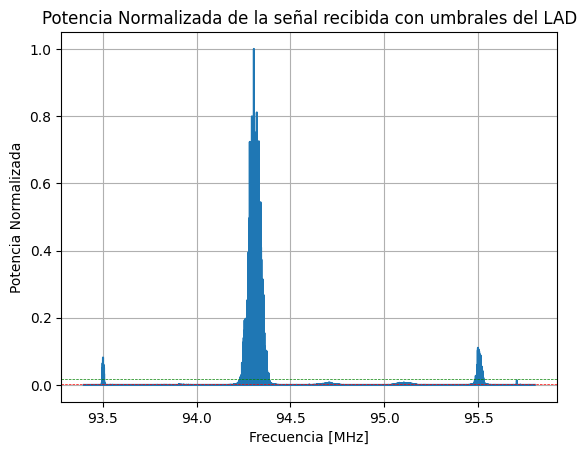

In [48]:
fig, signal_power_plot_t = plt.subplots()
signal_power_plot_t.plot(f_sdr_signal/frec_unit, power_of_signal_r)
signal_power_plot_t.axhline(y=tu, color='green', linestyle='--',linewidth=0.5)
signal_power_plot_t.axhline(y=tl, color='red', linestyle='--',linewidth=0.5)
signal_power_plot_t.grid()
signal_power_plot_t.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Potencia Normalizada')
plt.title('Potencia Normalizada de la señal recibida con umbrales del LAD')
plt.show()

Colocando los umbrales sobre el espectro que muestra la potencia normalizada en dB se tiene:

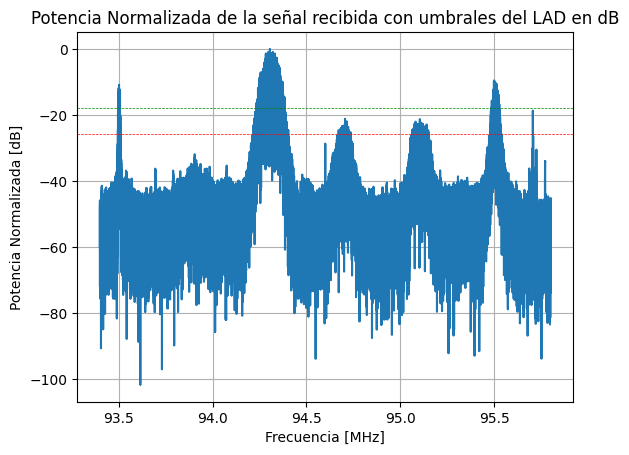

In [49]:
# Se pasan a dB los valores de los umbrales
tu_dB = (10.0*np.log10((tu)))
tl_dB = (10.0*np.log10((tl)))

fig, signal_power_db_plot_t = plt.subplots()
signal_power_db_plot_t.plot(f_sdr_signal/frec_unit, signal_power_dB)
signal_power_db_plot_t.axhline(y=tu_dB, color='green', linestyle='--',linewidth=0.5)
signal_power_db_plot_t.axhline(y=tl_dB, color='red', linestyle='--',linewidth=0.5)
signal_power_db_plot_t.grid()
signal_power_db_plot_t.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Potencia Normalizada [dB]')
plt.title('Potencia Normalizada de la señal recibida con umbrales del LAD en dB')
plt.show()

Una vez obtenidos los umbrales $T_{sup}$ y $T_{inf}$ se continúa con el método LAD, donde se deben agrupar las muestras de la señal en clusters considerando la energía de la señal.
Los clusters están formados por las muestras de la señal que superan el $T_{inf}$, por ejemplo si tenemos la siguiente señal:

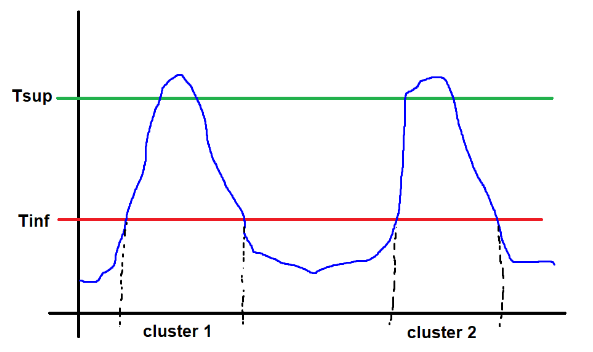

Se tendrían dos clusters, **cluster 1** y **cluster 2**.

Luego en cada uno de los clusters, si alguna de las muestras supera el $T_{sup}$, entonces se considera que es una señal y esta señal va a estar compuesta por todas las muestras de ese cluster.

En el ejemplo anterior se tendrían dos señales.

En el siguiente caso sólo se detectaría una única señal, la correspondiente a las muestras del **cluster 1**, ya que ninguna de las muestras del **cluster 2** supera el $T_{sup}$:

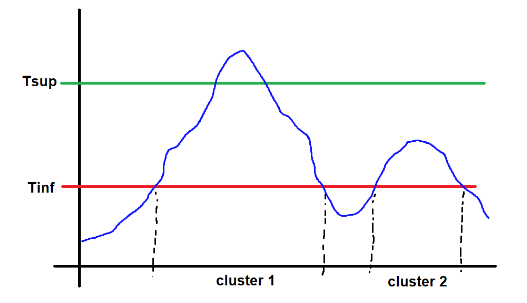

En el siguiente no se detectaría ninguna señal:

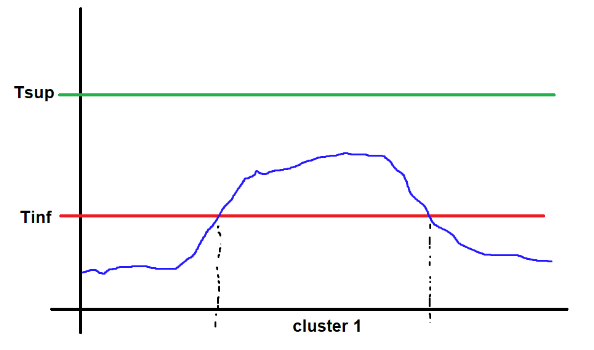

En el siguiente se detectaría una única señal:

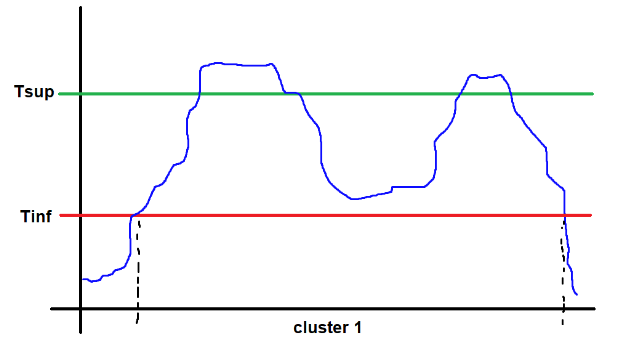

Considerando los casos anteriores se desarrolló un algoritmo para detectar los clusters de muestras que cumplen con la condición de señal en el espectro que estamos analizando:

In [50]:
# Identificacion de los clusters de muestras y me quedo con aquellos
# que cumplen con la condicion de señal a partir de los umbrales

cluster_aux = []

flag_saving_cluster = False

flag_saving_cluster_first_element = True

flag_cluster_signal = False

clusters_list = []

clusters_list_signal = []

for i in range(0,len(r_signal_array)):

   if r_signal_array[i][0] >= tl:
        flag_saving_cluster = True
        if (flag_saving_cluster_first_element == True):
           if(0 < i):
              cluster_aux.append(r_signal_array[i-1])
           flag_saving_cluster_first_element = False
        cluster_aux.append(r_signal_array[i])
        if r_signal_array[i][0] >= tu:
           flag_cluster_signal = True

   if((r_signal_array[i][0] < tl and flag_saving_cluster == True) or (i == (len(r_signal_array)-1) and flag_saving_cluster == True)):
      flag_saving_cluster = False
      flag_saving_cluster_first_element = True
      cluster_aux.append(r_signal_array[i])
      clusters_list.append(cluster_aux)
      if flag_cluster_signal == True:
         clusters_list_signal.append(cluster_aux)
      flag_cluster_signal = False
      cluster_aux = []

Considerando el espectro capturado en terminos de potencia normalizada en dB podemos marcar estos clusters que cumplen con la condición de señal e identificar cuantas serían las señales detectadas:

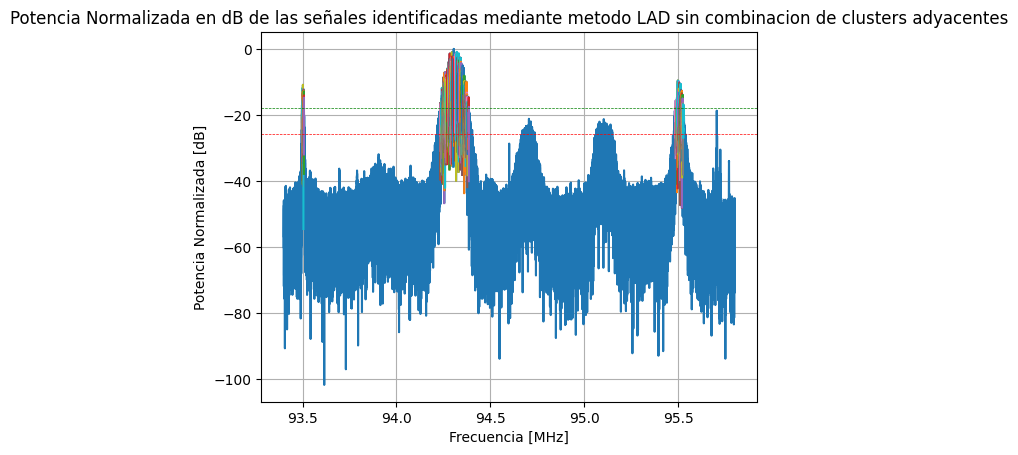

Cantidad de Señales detectadas mediante metodo LAD sin combinacion de clusters adyacentes: 
419


In [51]:
fig, signal_list_power_db_no_clus_ady = plt.subplots()
signal_list_power_db_no_clus_ady.plot(f_sdr_signal/frec_unit, signal_power_dB)
for i in range(0,len(clusters_list_signal)):
    signal_list_power_db_no_clus_ady.plot([(x[1]/frec_unit) for x in clusters_list_signal[i]], [(10.0*np.log10((y[0]))) for y in clusters_list_signal[i]])
signal_list_power_db_no_clus_ady.axhline(y=tu_dB, color='green', linestyle='--',linewidth=0.5)
signal_list_power_db_no_clus_ady.axhline(y=tl_dB, color='red', linestyle='--',linewidth=0.5)
signal_list_power_db_no_clus_ady.grid()
signal_list_power_db_no_clus_ady.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Potencia Normalizada [dB]')
plt.title('Potencia Normalizada en dB de las señales identificadas mediante metodo LAD sin combinacion de clusters adyacentes')
plt.show()

print("Cantidad de Señales detectadas mediante metodo LAD sin combinacion de clusters adyacentes: ")
print(len(clusters_list_signal))

A partir de los ejemplos y lo calculado anteriormente podríamos decir que se tiene un método para determinar que es una señal o no a partir de $T_{sup}$ y $T_{inf}$, pero si consideramos que la señal que se está analizando está atenuada debido al ruido, por ejemplo, estaríamos haciendo un análisis incorrecto de que es señal y que no lo es ya que algunas de las muestras que se encuentren por debajo de $T_{inf}$ estarían generando distintos cluster y consecuentemente varias señales, cuando en realidad puede que no sea así. Por lo tanto al método LAD se le puede aplicar la siguiente mejora llamada **LAD con combinación de clusters adyacentes**, el cual consiste en, a partir de los clusters que cumplen la condición de señal, combinar aquellos que son adyacentes y que la cantidad de muestras (que se encuentran por debajo de $T_{inf}$) entre ambos clusters es menor o igual a un valor $n$. El resultado de la combinación es una única señal.

Por ejemplo si analizamos la siguiente señal:

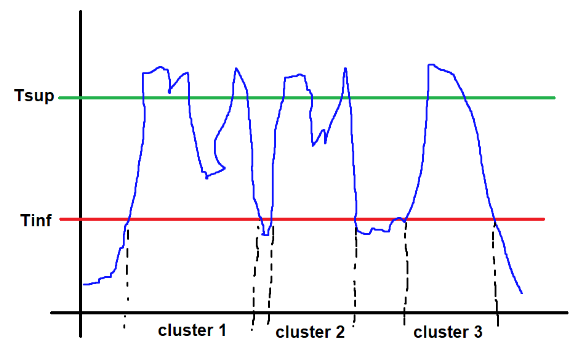

Sin aplicar la mejora de combinación de clusters adyacentes, estaríamos detectando 3 señales distintas, cuando en realidad es una única señal atenuada generando 3 clusters ya que algunas de sus muestras se encuentran por debajo de $T_{inf}$.

Por lo tanto se desarrolló un algoritmo para poder llevar a cabo la mejora de combinación de clusters adyacentes para los clusters identificados como señal del espectro que estamos analizando:

In [52]:
signal_aux = []

signal_list = []

# Tomo el primer cluster y lo agrego como la primer señal

for i in range(0,len(clusters_list_signal[0])):
   signal_aux.append(clusters_list_signal[0][i])

signal_list.append(signal_aux)

signal_aux = []

# Calculo el numero de muestras de distancia entre dos clusters para considerar que los mismos pertenecen a la misma señal
# a partir de la distancia en frecuencia especificada

num_samples = math.ceil(dist_frec/dist_of_samples)

# Luego empiezo a comparar la ultima señal agregada a signal_list con los clusters siguientes
# Por eso comienza en 1

for i in range(1,len(clusters_list_signal)):

   index_last_signal = len(signal_list)-1
   index_last_sample_last_signal = len(signal_list[index_last_signal])-1
   sample_id_last_sample_last_signal = signal_list[index_last_signal][index_last_sample_last_signal][1]

   sample_id_first_sample_current_cluster = clusters_list_signal[i][0][1]

   for j in range(0,len(clusters_list_signal[i])):
      signal_aux.append(clusters_list_signal[i][j])

   if((sample_id_first_sample_current_cluster - sample_id_last_sample_last_signal) <= num_samples):

      index_start_signal_aux = 0
      if((sample_id_first_sample_current_cluster - sample_id_last_sample_last_signal) == 0):
         index_start_signal_aux = 1

      for j in range(index_start_signal_aux,len(signal_aux)):
         signal_list[index_last_signal].append(signal_aux[j])

   else:

      signal_list.append(signal_aux)

   signal_aux = []

Considerando el espectro capturado en términos de potencia normalizada en dB podemos graficar los clusters resultantes de realizar la combinación:

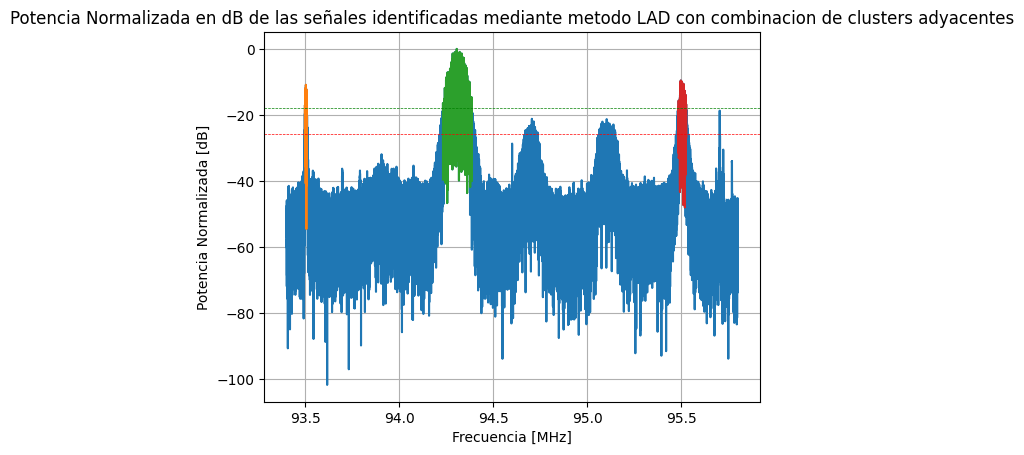

In [53]:
fig, signal_list_power_db = plt.subplots()
signal_list_power_db.plot(f_sdr_signal/frec_unit, signal_power_dB)
for i in range(0,len(signal_list)):
    signal_list_power_db.plot([(x[1]/frec_unit) for x in signal_list[i]], [(10.0*np.log10((y[0]))) for y in signal_list[i]])
signal_list_power_db.axhline(y=tu_dB, color='green', linestyle='--',linewidth=0.5)
signal_list_power_db.axhline(y=tl_dB, color='red', linestyle='--',linewidth=0.5)
signal_list_power_db.grid()
signal_list_power_db.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Potencia Normalizada [dB]')
plt.title('Potencia Normalizada en dB de las señales identificadas mediante metodo LAD con combinacion de clusters adyacentes')
plt.show()

Si lo vemos solo en términos de potencia normalizada se tiene:

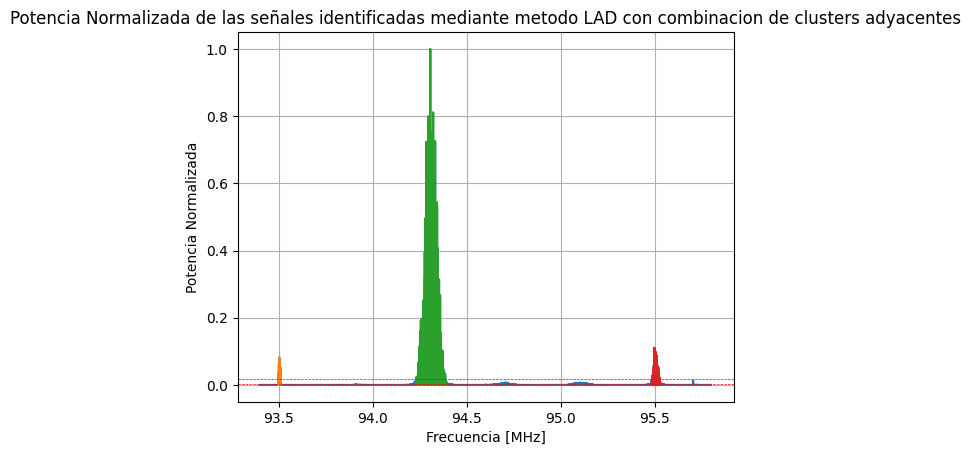

In [54]:
fig, signal_list_power = plt.subplots()
signal_list_power.plot(f_sdr_signal/frec_unit, power_of_signal_r)
for i in range(0,len(signal_list)):
    signal_list_power.plot([(x[1]/frec_unit) for x in signal_list[i]], [y[0] for y in signal_list[i]])
signal_list_power.axhline(y=tu, color='green', linestyle='--',linewidth=0.5)
signal_list_power.axhline(y=tl, color='red', linestyle='--',linewidth=0.5)
signal_list_power.grid()
signal_list_power.set(xlabel = 'Frecuencia [MHz]', ylabel = 'Potencia Normalizada')
plt.title('Potencia Normalizada de las señales identificadas mediante metodo LAD con combinacion de clusters adyacentes')
plt.show()

Y la cantidad de señales detectadas aplicando la mejora de combinación de clusters adyacentes es:

In [55]:
print("Cantidad de Señales detectadas mediante metodo LAD con combinacion de clusters adyacentes: ")
print(len(signal_list))

Cantidad de Señales detectadas mediante metodo LAD con combinacion de clusters adyacentes: 
3


De esta manera se puede observar que utilizando la mejora de combinación de clusters adyacentes obtenemos muchas menos señales y que se corresponden que con la identificación visual en el gráfico de cada una de las estaciones FM en el espectro caputrado.

## **Conclusión**

Se realizó el desarrollo de un método para el sensado de espectro basado en detección de energía, el método LAD (Location Algorithm based on double-thresholding), el cual sin información previa de las señales recibidas permitió la detección de las mismas presentes en un rango de frecuencias establecido.

Aplicando la combinación de clusters adyacentes permitió una mejora en la identificación de la cantidad de señales detectadas.

De esta forma podemos concluir que es un método muy eficaz para utilizar en radio cognitiva permitiendo detectar la presencia de usuarios primarios en determinados rangos de frecuencia y por consiguiente saber en qué instantes estos usuarios no se encuentran transmitiendo para que luego sean los usuarios secundarios los que aprovechen esos instantes para transmitir y de esa forma disminuir la infrautilización que se hace del espectro.

## **Referencias**

[1] Ángeles de la Cruz Barquero. Detección e Identificación de Señales para Radio Cognitiva. Universidad Carlos III de Madrid. 2013.<br><br>
[2] Mishel Victoria Zevallos Carrillo. Comparativo de los Métodos FCME y LAD para la Detección de Espacios Blancos en el Espectro Radioeléctrico del Canal 16 IRTP del Sistema de Televisión Digital Terrestre en el Estándar ISDB-TB. Universidad Tecnológica del Perú. 2019.<br><br>
[3] Johanna Vartiainen, Heli Sarvanko, Janne Lehtomaki, Markku Juntti and Matti Latva-aho. Spectrum Sensing with LAD-Based Methods. The 18th Annual IEEE International Symposium on Personal, Indoor and Mobile Radio Communications (PIMRC’07). 2007.<br><br>
[4] Marc Lichtman. PySDR: A Guide to SDR and DSP using Python.
https://pysdr.org/<br><br>